In [1]:
# Imports
import pandas as pd
import numpy as np

from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [2]:
# Load model 
topic_model = BERTopic.load("BERT_v1")

# Load sample data
transcripts = pd.read_csv('transcripts_sample_old.csv.gz', compression='gzip')

# Create list of transcripts
docs = list(transcripts['transcript'])

# Get document info
topic_doc = topic_model.get_document_info(docs)

In [4]:
# Filter out outliers
topic_doc_filter = topic_doc[topic_doc['Topic'] != -1]
topic_doc_filter.head()

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,Hello and welcome along to the property Academ...,13,13_filipinos_filipino_hindi_philippines,filipinos - filipino - hindi - philippines - i...,0.382109,False
1,"Good morning, everyone. This is Trinity here a...",62,62_ginger_deck_tarot_tepper,ginger - deck - tarot - tepper - 2020 - 2019 -...,0.957442,False
2,"Hey guys, it's Peter fry and welcome to the li...",5,5_anchor_podcast_album_weezer,anchor - podcast - album - weezer - song - guy...,1.000000,False
6,You have turned into functional fun. I'm Mike ...,14,14_insulin_fasting_keto_fat,insulin - fasting - keto - fat - intermittent ...,0.138242,False
8,"Hey everyone, before we continue with the show...",1,1_anxiety_mental_self_yourself,anxiety - mental - self - yourself - life - de...,0.915268,False


In [5]:
# doc_embeddings = topic_model.transform(docs)

# Embedd  documents
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(list(topic_doc_filter.Document), show_progress_bar=True)

Batches:   0%|          | 0/237 [00:00<?, ?it/s]

In [6]:
topic_doc_filter['Embeddings'] = list(embeddings)
topic_doc_filter.head(2)

,Document,Topic,Name,Top_n_words,Probability,Representative_document,Embeddings
0,Hello and welcome along to the property Academ...,13,13_filipinos_filipino_hindi_philippines,filipinos - filipino - hindi - philippines - i...,0.382109,False,"[0.058892757, -0.04167162, 0.047408547, 0.0528..."
1,"Good morning, everyone. This is Trinity here a...",62,62_ginger_deck_tarot_tepper,ginger - deck - tarot - tepper - 2020 - 2019 -...,0.957442,False,"[0.018057114, 0.021563027, 0.100678094, 0.0688..."


In [32]:
# Compute cosine similiarity/distance with document embeddings

sim_matrix = cosine_similarity(embeddings)
df_sim = pd.DataFrame(sim_matrix, columns=filtered_docs.index, index=filtered_docs.index)
df_sim

,0,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
0,1.000000,0.325963,0.435000,0.801560,0.579946,0.400170,0.439881,0.778909,0.349178,0.394905,...,0.375360,0.074975,0.512340,0.076624,0.645604,0.476304,0.015187,0.381138,0.084565,0.622441
1,0.325963,1.000000,0.222527,0.237422,0.296104,0.285267,0.230775,0.171831,0.118418,0.209681,...,0.388490,0.122732,0.161230,-0.007268,0.233492,0.318151,0.034612,0.238129,0.057116,0.235031
2,0.435000,0.222527,1.000000,0.353952,0.532962,0.358618,0.491175,0.297800,0.407624,0.386104,...,0.280616,0.158567,0.205688,0.197358,0.453097,0.297102,0.139913,0.338537,0.027177,0.315052
3,0.801560,0.237422,0.353952,1.000000,0.565680,0.324068,0.383789,0.781308,0.301149,0.310392,...,0.335415,0.024069,0.445647,0.082821,0.548983,0.433539,0.043995,0.304779,0.074871,0.629597
4,0.579946,0.296104,0.532962,0.565680,1.000000,0.522072,0.572657,0.517597,0.437201,0.422593,...,0.464335,0.177808,0.311586,0.227092,0.650440,0.502568,0.235382,0.399114,0.083400,0.527773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,0.476304,0.318151,0.297102,0.433539,0.502568,0.396334,0.353951,0.431497,0.305842,0.363402,...,0.511547,0.248596,0.224700,0.044908,0.426623,1.000000,0.118747,0.184538,0.044857,0.333814
368,0.015187,0.034612,0.139913,0.043995,0.235382,0.234381,0.140686,0.044589,0.118343,0.096952,...,0.154135,0.218236,0.028612,0.095556,0.231335,0.118747,1.000000,0.139937,-0.018508,0.043643
369,0.381138,0.238129,0.338537,0.304779,0.399114,0.405735,0.404301,0.290241,0.282914,0.374211,...,0.231758,0.105680,0.302483,0.072165,0.388343,0.184538,0.139937,1.000000,0.170573,0.323585
370,0.084565,0.057116,0.027177,0.074871,0.083400,0.126372,0.059775,0.094851,0.059487,0.208809,...,0.052848,0.040853,0.137243,0.099333,0.153465,0.044857,-0.018508,0.170573,1.000000,0.145142


In [47]:
# Convert cosine distance matrix to pair-wise dataframe
df_tri = pd.DataFrame(np.triu(df_sim), columns=df_sim.columns, index=df_sim.index)
df_long = df_tri.stack().reset_index()

# Rename the columns
df_long.columns = ['Pair_1', 'Pair_2', 'Cosine_Distance']

# Remove rows where Pair_1 is equal to Pair_2
df_long = df_long[df_long['Pair_1'] != df_long['Pair_2']]
df_long = df_long[df_long.Cosine_Distance !=0]

print('Shape:', df_long.shape)

Shape: (69006, 3)


Interpret df_long as an edge_weighted graph. Through that we can determine its diameter by finding the maximum edge weight since it is fully connected. 
diam(G)=max{distG,w(u,v)|u∈V(G),v∈V(G)}.

In [50]:
# Discriptive stats and plot dist
print(f'Max: {df_long.Cosine_Distance.max():.2f}')
print(f'Min: {df_long.Cosine_Distance.min():.2f}')

Max: 0.97
Min: -0.17


In [ ]:
# Get document embeddings for each topic
topic_embeddings = []
for topic_id in unique_topics:
    docs = topic_doc_filter.Document.where('Topic' == topic_id)
    embeddings = topic_model.transform(docs)
    topic_embeddings.append(embeddings)

# Compute cosine similarity matrix for each topic
similarity_matrices = []
for embeddings in topic_embeddings:
    sim_matrix = cosine_similarity(embeddings)
    similarity_matrices.append(sim_matrix)

# Create DataFrame to store similarity matrices
topic_labels = topic_model.get_topic_freq().index
dfs = []
for i, sim_matrix in enumerate(similarity_matrices):
    topic_label = topic_labels[i]
    df = pd.DataFrame(sim_matrix, columns=range(len(topic_model.get_documents(topic_label))),
                      index=range(len(topic_model.get_documents(topic_label))))
    df.columns = [f'{topic_label}_doc_{idx}' for idx in df.columns]
    df.index = [f'{topic_label}_doc_{idx}' for idx in df.index]
    dfs.append(df)

# Combine similarity matrices for all topics
df_cosine_similarities = pd.concat(dfs, axis=0)


### Try standardized method - Silhuette score

In [10]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [11]:
np.mean(silhouette_samples(embeddings, topic_doc_filter.Topic))

-0.046636842

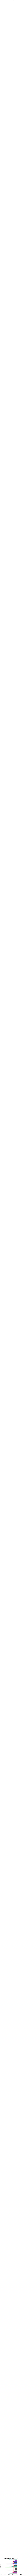

In [15]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embeddings, topic_doc_filter.Topic)
silhouette_avg = silhouette_score(embeddings, topic_doc_filter.Topic)

y_lower = 10

for i in topic_doc_filter.Topic:  #topic_doc_filter.Topic
# Aggregate the silhouette scores for samples belonging to
# cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[topic_doc_filter.Topic == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.ylim([0, len(embeddings) + (2 + 1) * 10])

    color = cm.nipy_spectral(float(i) / topic_doc_filter.Topic)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

# Label the silhouette plots with their cluster numbers at the middle
plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))


plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.show()